# 🤖 07_Overfitting_Check — Перевірка переобучення моделі
# Project: Прогнозування Відтоку Клієнтів
# Team Lead: Vitalii Subbotin
# Date: 2025-10-15
# ---------------------------------------------

In [1]:
# 1. Імпорт бібліотек
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import roc_auc_score

sns.set(style="whitegrid")

In [2]:
# 2. Шляхи
BASE_DIR = Path("..")
DATA_PATH = BASE_DIR / "data" / "df1_mean.csv"
MODELS_DIR = BASE_DIR / "models"
MODEL_PATH = MODELS_DIR / "best_model_lgb.pkl"
SCALER_PATH = MODELS_DIR / "scaler.pkl"

In [3]:
# 3. Завантаження даних і моделі
df = pd.read_csv(DATA_PATH)
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)
if 'Churn' in df.columns and 'churn' not in df.columns:
    df.rename(columns={'Churn': 'churn'}, inplace=True)

X = df.drop(columns=['churn'])
y = df['churn']

scaler = joblib.load(SCALER_PATH)
model = joblib.load(MODEL_PATH)
print("✅ Модель і scaler успішно завантажено.")

✅ Модель і scaler успішно завантажено.


In [4]:
# 4. Розділення на train/test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

binary_cols = [c for c in X.columns if X[c].nunique() <= 2]
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cols_to_scale = [c for c in num_cols if c not in binary_cols]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [6]:
# 5. Обчислення ROC-AUC на train і test
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"  # або кількість твоїх фізичних ядер

y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

roc_train = roc_auc_score(y_train, y_train_proba)
roc_test = roc_auc_score(y_test, y_test_proba)

print(f"\nROC-AUC Train: {roc_train:.4f}")
print(f"ROC-AUC Test : {roc_test:.4f}")
print(f"Різниця (train - test): {roc_train - roc_test:.4f}")


ROC-AUC Train: 0.9933
ROC-AUC Test : 0.9943
Різниця (train - test): -0.0010


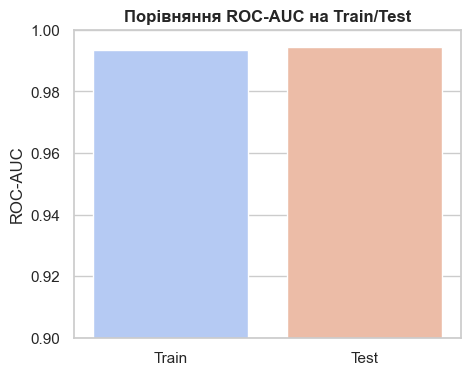

In [8]:
# 6. Візуалізація
x_vals = ["Train", "Test"]
y_vals = [roc_train, roc_test]

plt.figure(figsize=(5,4))
sns.barplot(x=x_vals, y=y_vals, hue=x_vals, palette="coolwarm", legend=False)
plt.title("Порівняння ROC-AUC на Train/Test", fontsize=12, fontweight="bold")
plt.ylabel("ROC-AUC")
plt.ylim(0.9, 1.0)
plt.show()

In [9]:
# 7. Висновок
diff = roc_train - roc_test
if diff < 0.01:
    print("✅ Модель збалансована — переобучення відсутнє або мінімальне.")
elif diff < 0.03:
    print("⚠️ Невелике переобучення, але в межах норми.")
else:
    print("🚨 Імовірне переобучення — модель занадто добре працює на train.")

✅ Модель збалансована — переобучення відсутнє або мінімальне.
